


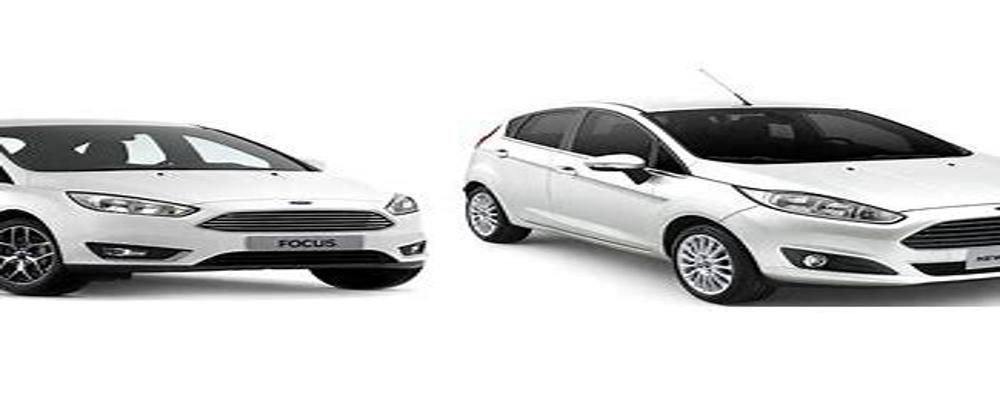

### Installing required libraries

In [1]:
%pip install nbformat plotly


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas numpy seaborn matplotlib scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


### Dataset URL from the IBM Data Science PC lab

The dataset can be found here: 

"https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0271EN-SkillsNetwork/labs/v1/m3/data/used_car_price_analysis.csv"

------------------------------------------


#### Uploading the dataset from Device


Downloading the dataset directly with Pyodide or requests is not feasible because of proxy issues.


First, click the link and download the file to your device. Then, upload it to your working directory.

In [4]:
import os
# This shows current working directory to read the csv file correctly
print(os.getcwd())  

# Lists all files in the directory
print(os.listdir())  


/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801
['.vimrc', '.jupyter', '.ipynb_checkpoints', '.anaconda', '.pythonstartup.py', 'Car_Price_Analysis.ipynb', '.local', 'Model_resized.jpg', 'Model.jpg', '.npm', 'Laptop_Analysis.ipynb', '.gitconfig', 'GenAI_Prompt.ipynb', 'anaconda_projects', 'used_car_price_analysis.csv', 'Laptop', '.virtualenvs', '.profile', '.bashrc', '.ipython', '.cache', '.config', 'README.ipynb']


I found my working directory to be: **/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801**


Obviously, this will be different for a different user. For more clarity, I copied the directory and include the  the csv file name. See the code below.

In [5]:
# Load dataset
df = pd.read_csv("/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/used_car_price_analysis.csv")

# Display first few rows
df.head()


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,Fiesta,2017,Automatic,15944,Petrol,150.0,57.7,1.0,12000
1,Focus,2018,Manual,9083,Petrol,150.0,57.7,1.0,14000
2,Focus,2017,Manual,12456,Petrol,150.0,57.7,1.0,13000
3,Fiesta,2019,Manual,10460,Petrol,145.0,40.3,1.5,17500
4,Fiesta,2019,Automatic,1482,Petrol,145.0,48.7,1.0,16500


In [6]:
# Dataset size
print('The size of the dataset:',df.shape)

The size of the dataset: (17966, 9)


## Data Cleaning

Let's verify missing values, and remove duplicates.

In [8]:
# Identify columns with missing values
missing_values = df.isnull().sum()
print("Columns with missing values:\n", missing_values)

# Convert categorical columns to NaN- Handling unknown values
categorical_cols = df.select_dtypes(include=["object"]).columns
df[categorical_cols] = df[categorical_cols].replace("?", None) 

# Select only numeric columns for replacing missing values with mean
numeric_cols = df.select_dtypes(include=["number"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Remove duplicate entries
df.drop_duplicates(inplace=True)

# Display cleaned dataset
print("Cleaned DataFrame:\n", df.head())


Columns with missing values:
 model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64
Cleaned DataFrame:
      model  year transmission  mileage fuelType    tax   mpg  engineSize  \
0   Fiesta  2017    Automatic    15944   Petrol  150.0  57.7         1.0   
1    Focus  2018       Manual     9083   Petrol  150.0  57.7         1.0   
2    Focus  2017       Manual    12456   Petrol  150.0  57.7         1.0   
3   Fiesta  2019       Manual    10460   Petrol  145.0  40.3         1.5   
4   Fiesta  2019    Automatic     1482   Petrol  145.0  48.7         1.0   

   price  
0  12000  
1  14000  
2  13000  
3  17500  
4  16500  


In [16]:
# Glimpse of summary statistics (without the column 'year')
print('Summary Statistics:\n', df.drop(columns=['year']).describe().round(2))

Summary Statistics:
          mileage       tax       mpg  engineSize     price
count   17812.00  17812.00  17812.00    17812.00  17812.00
mean    23381.15    113.31     57.91        1.35  12269.56
std     19419.01     62.03     10.13        0.43   4736.29
min         1.00      0.00     20.80        0.00    495.00
25%     10000.00     30.00     52.30        1.00   8999.00
50%     18277.00    145.00     58.90        1.20  11288.00
75%     31098.50    145.00     65.70        1.50  15295.00
max    177644.00    580.00    201.80        5.00  54995.00


#### Mileage Feature
Approximately 23,38 miles on average is the typical vehicle usage, and the range is 1.00 to 177644 miles. High-mileage vehicles likely sell for lower prices, while lower-mileage cars may demand a premium. 25% of the cars are at 10000 miles, which is normal since the data is about used cars.

#### Tax Feature
The mean tax is 113 dollars and varies from 0 to 500 dollars. 25% of cars have taxes below 30, while 75% are taxed at $145. The variation might be explained by tax exemption for certain vehicles, or a tax policy based on **fuel emissions**. The lower the tax costs, the better it will be for buyers with constrained budgets.

#### MPG Feature
The mean MPG is approximately 57.9 miles per gallon, with a range of  20.8 to 201.8 MPG, suggesting that some vehicles are extremely fuel-efficient. Cars with higher MPG (especially hybrids/electric) could be more appealing for buyers when fuel prices go up.
 
#### Engine Size Feature
The mean of engine size is 1.35 liters, and the range is 0.0 to 5.0 liters. The 0.0 liters indicate the use of electric engines. 50% of cars have engines less than or equal to 1.2 liters, indicating that more compact models dominate the market. Larger engine vehicles, those greater or equal to 1.5 liters, suggest higher performance and are thus to be premium models.

#### Price Feature
The mean price is  12,269 dollars, and the range is 495-54,995 dollars. This large disparity might be due to different car conditions, brands, and features. 25% of vehicles, when the price is less than or equal to 8,999 dollars, suggest cheaper purchases. 75% of vehicles, when the price is greater than or equal to $15,295, indicate the premium models in the market. Being top of the quartile, the premium model dominates the lower price range.


## Business Implications

1. Used car buyers will likely prioritize low-tax and high-MPG models (if fuel prices increase).

2. Dealerships can stock more low-mileage and budget-friendly cars to target mid-range customers.

3. Premium models will cater to a smaller market.

---

 **Identifying the 5 attributes that have the highest correlation with the price parameter.**

In [47]:
# Compute correlation matrix with only numerical colunms
correlation_matrix = df[numeric_cols].corr()

# The target attribute 
target_attribute = "price"

# Identify the top 5 attributes with highest correlation
top_attributes = correlation_matrix[target_attribute].abs().sort_values(ascending=False).index[1:6]

# Print the top 5 correlated attributes
print("Top 5 attributes with highest correlation to", target_attribute, ":\n", top_attributes)


Top 5 attributes with highest correlation to price :
 Index(['year', 'mileage', 'engineSize', 'tax', 'mpg'], dtype='object')


---

**Visualization of the top 5 attributes with a heatmap**

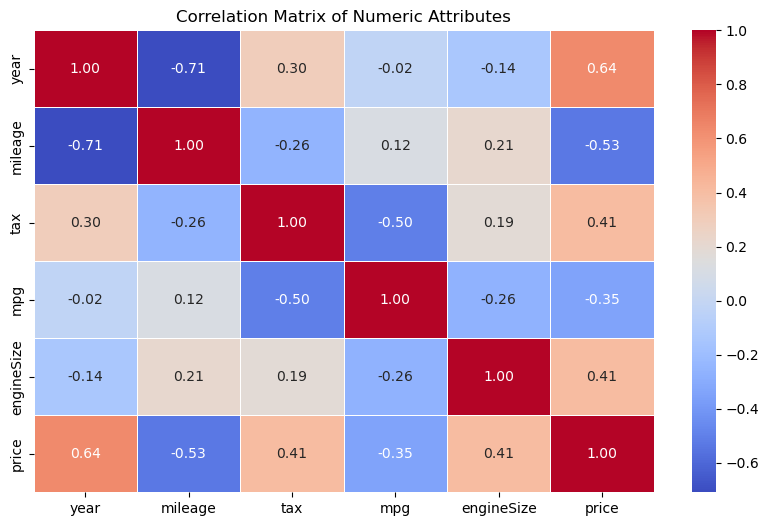

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Attributes")
plt.show()


---

**Some insights about the number of cars under each unique value of 'fuelType' attribute.**

In [26]:
# Specifying the column fuelType
column_name = "fuelType" 

# Count the occurrences of each unique value
value_counts = df[column_name].value_counts()
print("Count of unique values in", column_name, ":\n", value_counts)


Count of unique values in fuelType :
 fuelType
Petrol      12081
Diesel       5706
Hybrid         22
Electric        2
Other           1
Name: count, dtype: int64


 **Remarks** : 
1. Petrol cars dominate the market, showing strong consumer preference.
2. Diesel is significantly lower, but still holds a notable presence in the market.
3. Hybrid & Electric cars are rare, indicating low demand and utility (Susceptible to premium pricing).
4. The low numbers of hybrids or electrics might suggest barriers such as high cost, limited charging infrastructure, or consumer hesitation. The instant the trend shifts, consumers will have more incentive to buy Electric/Hybrid cars.

---

## Data Exploration and Visualization

Creating a Box plot with the Seaborn library to determine whether cars with automatic, manual or semi-auto type of transmission have more price outliers.

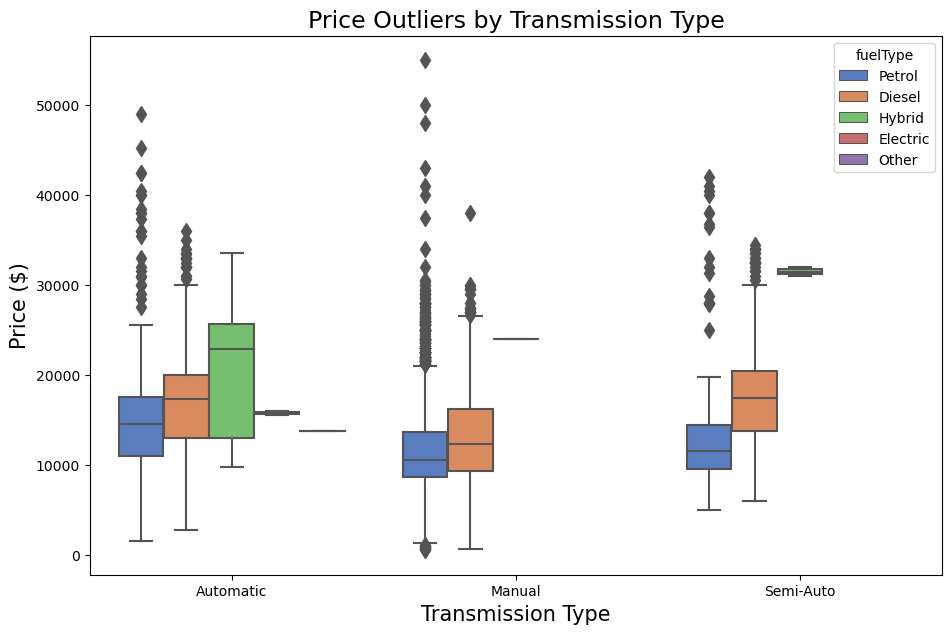

In [87]:
# Create a Seaborn box plot for transmission vs. price
plt.figure(figsize=(11, 7))
sns.boxplot(x=df["transmission"], y=df["price"], palette='muted',fliersize=8, width=0.8, hue='fuelType', data=df)

plt.title("Price Outliers by Transmission Type", fontsize=17)
plt.xlabel("Transmission Type", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)

plt.show()


The findings suggest that manual transmission vehicles have more price outliers compared to semi-auto and automatic cars. 

##### Factors that can explain this:

1. Some manual cars are "economy" models. It often leads to low-price outliers. Other models are high-performance sports cars, contributing to high-price outliers.

2. Declining demand for manual cars and the fact that they are harder to resell may lead to variable pricing, with some sellers drastically lowering prices to attract buyers, while luxury manual cars demand premium prices.

3. Automatic cars are the Standard and more popular. Most modern cars use an automatic transmission, making their pricing more predictable and consistent than the others.

---

Generating a regression plot between mpg parameter and the price to determine the correlation type between the two.


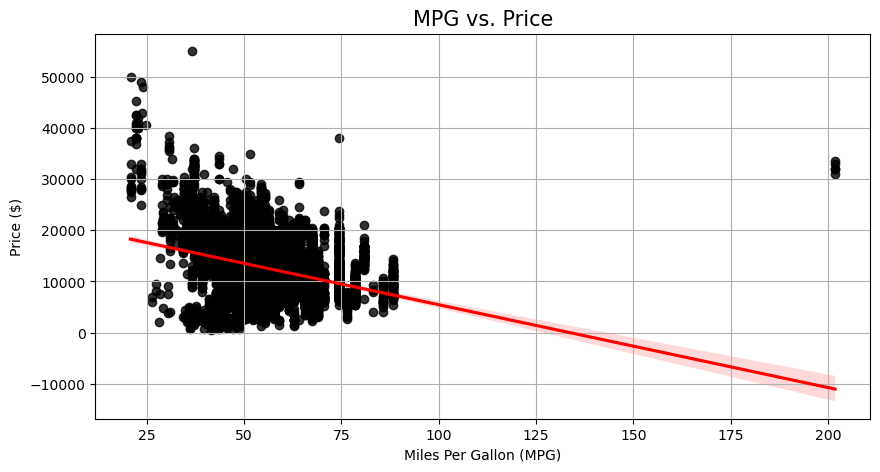

In [91]:
# Create a regression plot for mpg vs. price
plt.figure(figsize=(10, 5))
sns.regplot(x=df["mpg"], y=df["price"], scatter_kws={"color": "black"}, line_kws={"color": "red"})

plt.title("MPG vs. Price", fontsize=15)
plt.xlabel("Miles Per Gallon (MPG)")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()


The more MPG a car has, the lower its price is, on average.

---

## Data Preprocessing and Building Machine Learning Models


Let' try first to fit a linear regression model to predict the price using the feature mpg. Then, calculate the R^2 and MSE values for the model.


In [19]:
# Selecting features (X) and target variable (y)
X = df[["mpg"]]  
y = df["price"] 

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Calculate R^2 and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print results
print("R^2 Score:", r2)
print("Mean Squared Error (MSE):", mse)

R^2 Score: 0.1504343741072468
Mean Squared Error (MSE): 19049855.14011078


R^2 is very low and MSE is very high. The MPG feature should not be the only predictor to explain price variations

---

Now, let's predict the price on year, mileage, tax, mpg, and engineSize features to improve the model.
Then, re-calculate the R^2 and MSE values for this model.

R^2 Score: 0.6917125923771653
Mean Squared Error (MSE): 6912744.910746489


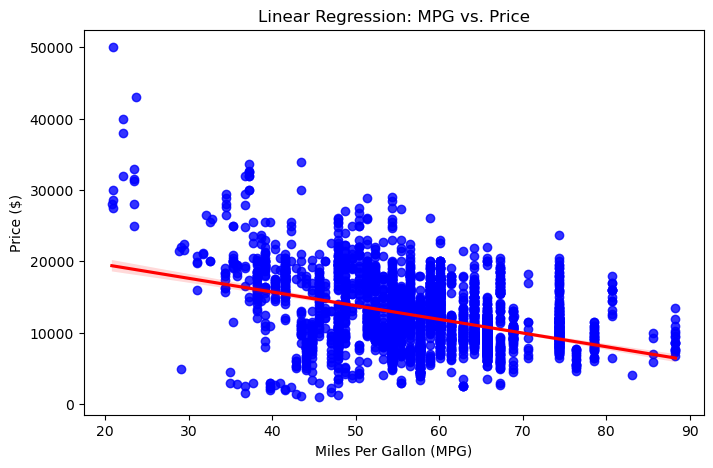

In [20]:
# Adding more features
features = ["year", "mileage", "tax", "mpg", "engineSize"]
X = df[features]  
y = df["price"] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate R^2 and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R^2 Score:", r2)
print("Mean Squared Error (MSE):", mse)

# Plot regression results with test data
plt.figure(figsize=(8, 5))
sns.regplot(x=X_test["mpg"], y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title("Linear Regression: MPG vs. Price")
plt.xlabel("Miles Per Gallon (MPG)")
plt.ylabel("Price ($)")
plt.show()


The R^2 and MSE improved significantly!!!

An R^2 score of 69.17% means that the model explains 69.17% of the variance in car prices based on the selected  features. It also suggests that about 30.83% of the price variation is unexplained by the model.

##### Limitations of this model:
1. The non-inclusion of the categorical variables ('fuelType' and 'transmission').
2. Since it’s not above 80-90%, other predictive features affecting car prices are missing from the dataset.

---

## Pipeline and Ridge Regression

Let's create a pipeline model object that uses standard scalar, second degree polynomial features and a linear regression model. 

Then, creating a Ridge Regression object to fit the data

In [106]:
# Selecting features and target variable
features = ["year", "mileage", "tax", "mpg", "engineSize"]
X = df[features]  
y = df["price"]

# Splitting data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline with StandardScaler, PolynomialFeatures (degree 2), and Linear Regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("linear_regression", LinearRegression())
])

# Fitting the pipeline model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_pipeline = pipeline.predict(X_test)

# Calculate R^2 and MSE for the pipeline model
r2_pipeline = r2_score(y_test, y_pred_pipeline)
mse_pipeline = mean_squared_error(y_test, y_pred_pipeline)

print("Pipeline Model - R^2 Score:", r2_pipeline)
print("Pipeline Model - Mean Squared Error (MSE):", mse_pipeline)

# Creating and fitting a Ridge regression model with regularization parameter 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# Making predictions using Ridge regression
y_pred_ridge = ridge_model.predict(X_test)

# Calculate R^2 and MSE for Ridge regression
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("Ridge Regression - R^2 Score:", r2_ridge)
print("Ridge Regression - Mean Squared Error (MSE):", mse_ridge)


Pipeline Model - R^2 Score: 0.12122807147170789
Pipeline Model - Mean Squared Error (MSE): 19704749.614920296
Ridge Regression - R^2 Score: 0.6917134446113168
Ridge Regression - Mean Squared Error (MSE): 6912725.801054858


**The Ridge Regression model significantly improved compared to the pipeline model. The Ridge Regression model prevents overfitting by  the regularization of large coefficients.** 

---

Let's perform a second-order polynomial transform on both the training data and testing data. Then, let's create and fit a Ridge regression object using the modified training data, and set the regularization parameter to 100.

In [101]:
# Selecting features and target variable
features = ["year", "mileage", "tax", "mpg", "engineSize"]
X = df[features]  
y = df["price"] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply second-degree polynomial transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardize the transformed features
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

# Create and fit a Ridge regression model with a regularization parameter of 100
ridge_model = Ridge(alpha=100)
ridge_model.fit(X_train_poly, y_train)

# Make predictions using Ridge regression
y_pred_ridge = ridge_model.predict(X_test_poly)

# Calculate R^2 and MSE for Ridge regression
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

# Print results
print("Ridge Regression - R^2 Score:", r2_ridge)
print("Ridge Regression - Mean Squared Error (MSE):", mse_ridge)


Ridge Regression - R^2 Score: 0.7034998093772302
Ridge Regression - Mean Squared Error (MSE): 6648439.5180696985


A higher alpha improved the model with a R^2 equal to 70.35% and a lower MSE - the errors got slightly closer to the actual values.

----------------

## Hyperparameter Tuning (Grid Search)

We will perform a Grid Search on  a ridge regression for a set of values of alpha {0.01, 0.1, 1, 10, 100} with 4-fold cross validation to find the optimum value of alpha to be used for the prediction model.


In [107]:
# Select features and target variable
features = ["year", "mileage", "tax", "mpg", "engineSize"]
X = df[features] 
y = df["price"]

# Splitting data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying second-degree polynomial transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardizing the transformed features
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

# Defining Ridge regression model
ridge = Ridge()

# Defining parameter grid for alpha values
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Perform Grid Search with 4-fold cross-validation
grid_search = GridSearchCV(ridge, param_grid, cv=4, scoring="r2")
grid_search.fit(X_train_poly, y_train)

# Getting the best alpha value
best_alpha = grid_search.best_params_["alpha"]
print("Best Alpha for Ridge Regression:", best_alpha)

# Fitting Ridge regression model using the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_poly, y_train)

# Making predictions using Ridge regression
y_pred_ridge = ridge_best.predict(X_test_poly)

# Calculate R² and MSE for Ridge regression
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

# Print results
print("Ridge Regression - R^2 Score:", r2_ridge)
print("Ridge Regression - Mean Squared Error (MSE):", mse_ridge)


Best Alpha for Ridge Regression: 0.01
Ridge Regression - R^2 Score: 0.6011362813118841
Ridge Regression - Mean Squared Error (MSE): 8943742.343235638


The GridSearchCV resulted in a slightly lower R^2 = 0.6011. The reason for this might be because of the high variance of this dataset. GridSearchCV work best with 'smoother' models ie low variance.

##### Conclusion:
1. Picking the alpha=100 is what is working best for this dataset because it reduces the impact of features with high noise.
2. Overfitting was prevented, leading to a certain stability and better generalization of .

## Presented by:


#### [**Carl Legros**](https://www.linkedin.com/feed/)